# Get LASTFM tracks similar to FMA tracks

`TODO` (doing between this & the jupyter `FMA_feature_to_genre_model.ipynb`)

Steps:
1. Get the subset of LASTFM containing tags comparable to genres. Preprocess the genres, an one-hot encoded CSV for the genres (output)
2. Select, from the features, only those from this subset (so that the file to work with is smaller)
3. Select, from those features, a subset we will use for training. Aim for similar amount of features than FMA, and similar names
4. Use the same model used in FMA to train a model to predict genres based on the features, and extract the embeddings
5. Check the correlation between song embeddings & the song similarity dataset
6. Think on how to link that with FMA ;?

In `FMA_feature_to_genre_model.ipynb` we have trained a model capable to extract similarity song embeddings by using as input the features of the song, and as outputs the genres.

We haven't been able to connect MSD and FMA in the level of features. Let's see how to connect them.
Instead of using MSD, we will use its subset: LASTFM, which contains more information, including genres, similar tracks, etc.

This dataset will:
* Convert the LASTFM genres into genres equivalent to those in FMA
* Convert the LASTFM features into those equivalent in FMA

In [13]:
__import__('sys').path.append('../scripts/'); __import__('notebook_utils').table_of_contents('MSD_genre_to_embedding.ipynb')

<h3>Table of contents</h3>


[Get LASTFM tracks similar to FMA tracks](#Get-LASTFM-tracks-similar-to-FMA-tracks)
- [Setup](#Setup)
- [Compare genres between FMA & LASTFM](#Compare-genres-between-FMA-&-LASTFM)
- [Compare low-level features between FMA & LASTFM](#Compare-low-level-features-between-FMA-&-LASTFM)

## Setup

In [8]:
# IMPORTS
import re
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
import h5py
from collections import Counter
import difflib

# import markdown
from IPython.display import Markdown

def md(text):
    print(Markdown(text))

In [9]:
# PATHS
class paths():
    DATA_D = '../data/' # path to the data folder
    MSD_D = '../data/MSD/' # path to the MSD dataset
    FMA_D = '../data/FMA/fma_metadata/' # path to the FMA metadata files
    TEMP_D = '../data/temp/'

    FMA_FEATURE = FMA_D + 'features.csv' # features for each track
    FMA_TRACKS = FMA_D + 'tracks.csv' # metadata for every track. We only use the genre column
    FMA_GENRE = FMA_D + 'genres.csv' # genre key from ID to string

    FMA_SMALL_D = '../data/FMA/fma_small/' # path to the FMA small dataset

    # MSD
    MSD_SUMMARY = MSD_D + 'msd_summary_file.h5'
    LASTFM_TRAIN_f = MSD_D + 'lastfm_train/'
    LASTFM_TEST_F = MSD_D + 'lastfm_test/'
    LASTFM_SIMILAR_TRACKS = MSD_D + 'tracks_with_similar.txt'

In [10]:
# LOAD FMA METADATA
def load_FMA(filepath):
    # Copied from FMA utils.py file

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')

        # the categories and ordered arguments were removed in pandas 0.25
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype(pd.CategoricalDtype())

        return tracks
   
FMA_tracks = load_FMA(paths.FMA_TRACKS)
FMA_genres = load_FMA(paths.FMA_GENRE)
FMA_features = load_FMA(paths.FMA_FEATURE)

## Get LASTFM genres matching with FMA

There are 16 parent genres in the FMA dataset
International, Blues, Jazz, Classical, Old-Time / Historic, Country, Pop, Rock, Easy Listening, Soul-RnB, Electronic, Folk, Spoken, Hip-Hop, Experimental, Instrumental
<IPython.core.display.Markdown object>


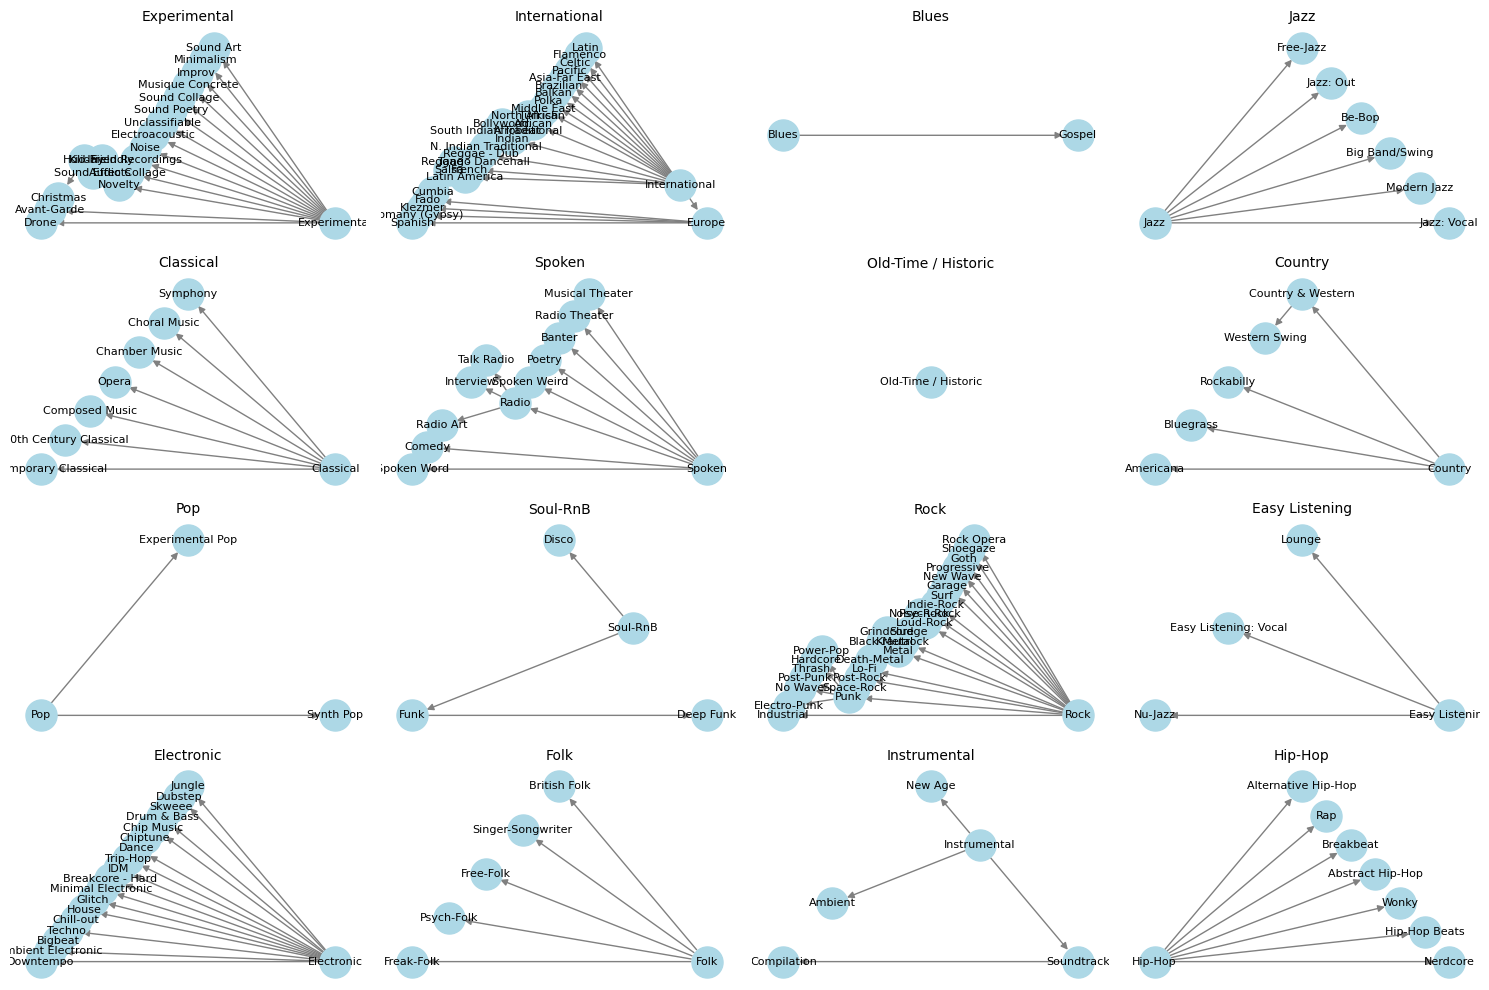

In [11]:
# DISPLAY DATA & GRAPHS ON FMA GENE HIERARCHY
# List parent terms
parent_terms = FMA_genres[FMA_genres['parent'] == 0]
print(f"There are {len(parent_terms)} parent genres in the FMA dataset")
print(f"{', '.join(parent_terms['title'])}")

import networkx as nx
def show_genes_hierarchy(FMA_genres):
    '''Show the hierarchy of genres in the FMA dataset using one directed graph per top-level genre.'''

    # Initialise the graph
    G = nx.DiGraph()

    # Add edges to the graph based on the parent-child relationships
    for genre_id, row in FMA_genres.iterrows():
        genre_name = row['title']
        parent_id = row['parent']
        
        # Determine the node level (subset) based on parent existence
        if parent_id != 0 and parent_id in FMA_genres.index:
            parent_name = FMA_genres.loc[parent_id, 'title']
            G.add_edge(parent_name, genre_name)
            G.nodes[genre_name]['subset'] = G.nodes[parent_name].get('subset', 0) + 1
        else:
            G.add_node(genre_name, subset=0)  # Top-level genres as subset 0
    # Identify the root nodes (nodes with no incoming edges)
    root_nodes = [node for node in G.nodes if G.in_degree(node) == 0]

    # Create a plot for each root and its corresponding tree
    num_roots = len(root_nodes)
    plt.figure(figsize=(15, 10))

    # Determine the grid layout for the subplots
    rows = cols = 4

    for i, root in enumerate(root_nodes):
        # Create a subgraph for each tree starting from the root
        nodes_in_tree = nx.descendants(G, root) | {root}
        tree = G.subgraph(nodes_in_tree)
        
        # Create a planar layout for the tree
        plt.subplot(rows, cols, i + 1)
        pos = nx.planar_layout(tree)
        nx.draw(tree, pos, with_labels=True, edge_color='gray', 
                node_size=500, font_size=8, arrows=True, node_color='lightblue')
        plt.title(root, fontsize=10)

    plt.tight_layout()
    md("Individual Trees for Each Top-Level Genre:")
    plt.show()

# Show graphs for the hierarchy of genres
show_genes_hierarchy(FMA_genres)

We will use the LASTFM dataset, instead of the whole MSD, as the LASTFM contains tags, features, and similar songs we can directly implement to MelodyMatch.

In [26]:
# GET ALL INFO FROM LASTFM
def get_LASTFM_all():
    '''Obtain all tags from the LASTFM dataset.
    First time, it creates a dictionary and saves it to temp/ folder.
    Second time, it loads the dictionary
    '''
    # Create the dictionary otherwise
    lastfm_dict = {}
    for path in [paths.LASTFM_TRAIN_f, paths.LASTFM_TEST_F]:
        for root, dirs, files in os.walk(path):
            if files:
                for file in files:
                    track_dict = json.load(open(os.path.join(root, file)))
                    track_id = track_dict['track_id'].strip("'")
                    lastfm_dict[track_id] = track_dict
    
    return lastfm_dict

lastfm_dict = get_LASTFM_all()

: 

In [12]:
# GET TAGS FROM LASTFM
def get_LASTFM_tags_dict():
    '''Obtain all tags from the LASTFM dataset.
    First time, it creates a dictionary and saves it to temp/ folder.
    Second time, it loads the dictionary
    '''
    store_path = paths.DATA_D + 'temp/LASTFM_tags_dict.json'

    # Load the dictionary if it exists
    if os.path.exists(store_path):
        with open(store_path, 'r') as f:
            return json.load(f)

    # Create the dictionary otherwise
    tags_dict = {}
    for path in [paths.LASTFM_TRAIN_f, paths.LASTFM_TEST_F]:
        for root, dirs, files in os.walk(path):
            if files:
                for file in files:
                    track_dict = json.load(open(os.path.join(root, file)))
                    tags = track_dict['tags']
                    if tags:
                        track_id = track_dict['track_id'].strip("'")
                        tags_dict[track_id] = tags

    # Save the dictionary
    json.dump(tags_dict, open(store_path, 'w'))
    
    return tags_dict

LASTFM_tags_dict = get_LASTFM_tags_dict()

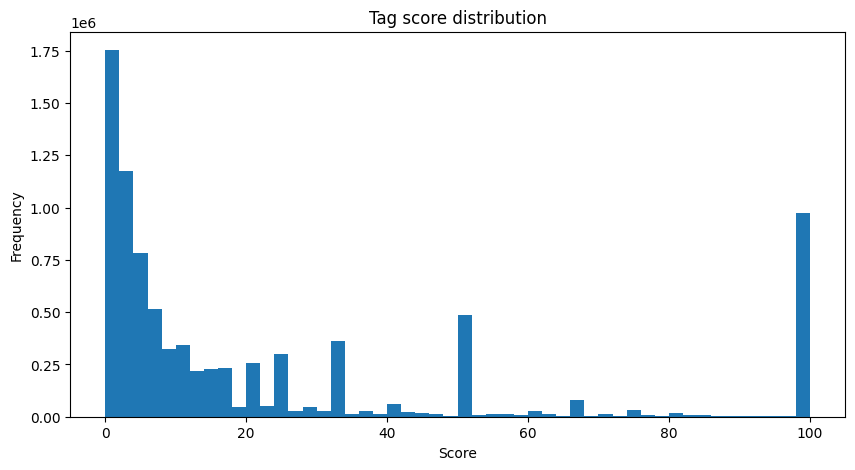

In [13]:
# PLOT SCORE DISTRIBUTION
def plot_tag_scores_distribution(LASTFM_tags_dict):
    scores = [int(score) for values in LASTFM_tags_dict.values() for t, score in values]

    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=50)
    plt.title('Tag score distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

plot_tag_scores_distribution(LASTFM_tags_dict)

In some cases, LASTFM and FMA genres match, but have slightly different names. We have created a manual mapping for the most common LASTFM genres to FMA genres to increase the amount of LASTFM genres with matching genres with LASTFM. For that, we have manually checked the most common tags without mapping in LASTFM, and tried to match them with a genre in FMA.

Mapping is inside `map_common_LASTFM_tags_to_genres`. To show the logic used, **uncomment the line using the function `show_most_common_LASTFM_tags`**

For that, we use difflib to find the most similar FMA track to the most common 50 LASTFM non-matched tags, and manually create a mapping for those we consider to map

In [20]:
# LASTFM TAGS PREPROCESSING

def clean_LASTFM_tags(LASTFM_tags_dict):
    '''Only keep tags with a score above 50, convert to lowercase, and replace '-' with ' '.'''

    # Filter tags with score > 50
    LASTFM_tags_dict_50 = {track_id: [tag.lower().replace('-', ' ') # Convert to lowercase and replace '-'
                                    for tag, score in tags if int(score) > 50] # Keep only tags with score > 50
                                    for track_id, tags in LASTFM_tags_dict.items()}
    # Remove empty tags
    LASTFM_tags_dict_50 = {track_id: tags for track_id, tags in LASTFM_tags_dict_50.items() if tags}

    return LASTFM_tags_dict_50

def get_tags_genres_set(LASTFM_tags_dict_50, FMA_genres):
    # Get unique tags for LASTFM & FMA
    LASTFM_tags_set = set(t for tags in LASTFM_tags_dict_50.values() for t in tags)
    FMA_genres_set = set(g.lower().replace('-', ' ') for g in FMA_genres['title'])
    return LASTFM_tags_set, FMA_genres_set

def map_common_LASTFM_tags_to_genres(LASTFM_tags_dict_50, LASTFM_tags_set, FMA_genres_set):
    matching_tags = FMA_genres_set.intersection(LASTFM_tags_set)

    # Manually created mapping between LASTFM tags & FMA genres:
    MSD_FMA_genre_mapping = {
        'indie': 'indie rock',
        'classic': 'classical',
        'electronica': 'electronic',
        'electro': 'electronic',
        'soul': 'soul rnb',
        'rnb': 'soul rnb',
        'chillout': 'chill out',
        'chill': 'chill out',
        'minimal': 'minimalism',
        'reggae dancehall': 'dancehall',
        'synthpop': 'synth pop',
        **{tag: 'jazz' for tag in LASTFM_tags_set if 'jazz' in tag and tag not in matching_tags},  # All with the word jazz
        **{tag: 'rock' for tag in LASTFM_tags_set if 'rock' in tag and tag not in matching_tags},
        **{tag: 'metal' for tag in LASTFM_tags_set if 'metal' in tag and tag not in matching_tags},
    }

    # Apply the mapping
    LASTFM_tags_dict_50_mapped = {
        track_id: [MSD_FMA_genre_mapping[tag] if tag in MSD_FMA_genre_mapping else tag for tag in tags]
        for track_id, tags in LASTFM_tags_dict_50.items()
    }

    return LASTFM_tags_dict_50_mapped

def create_genre_parent_mapping(FMA_genres):
    """
    Map each genre name to a list of all its parent terms.
    Make it lowercase and replace '-' with ' '.
    """
    
    genre_mapping = {}  # Initialize the dictionary to hold genre-to-parent mappings
    
    for genre_id, row in FMA_genres.iterrows():
        genre_name = row['title'].lower().replace('-', ' ')
        parent_id = row['parent']
        parent_terms = []
        
        # Traverse up the parent hierarchy
        while parent_id != 0:
            parent_row = FMA_genres.loc[parent_id]
            parent_name = parent_row['title'].lower().replace('-', ' ')
            parent_terms.append(parent_name)
            parent_id = parent_row['parent']
        
        genre_mapping[genre_name] = parent_terms  # Store the parent terms list for the genre
    
    return genre_mapping

def expand_track_genres(LASTFM_genres_dict, genre_parent_mapping):
    """Expand each track's genres to include all parent genres."""
    expanded_genres_dict = {}
    
    for track_id, genres in LASTFM_genres_dict.items():
        all_genres = set()
        
        for genre in genres:
            genre = genre.lower().replace('-', ' ')
            all_genres.add(genre)  # Add the genre itself
            if genre in genre_parent_mapping:
                all_genres.update(genre_parent_mapping[genre])  # Add parent genres
        
        expanded_genres_dict[track_id] = list(all_genres)
    
    return expanded_genres_dict


# Prepare the data
LASTFM_tags_dict_50 = clean_LASTFM_tags(LASTFM_tags_dict)
LASTFM_tags_set, FMA_genres_set = get_tags_genres_set(LASTFM_tags_dict_50, FMA_genres)

# Map the common tags to FMA genres
LASTFM_tags_dict_50_mapped = map_common_LASTFM_tags_to_genres(LASTFM_tags_dict_50, LASTFM_tags_set, FMA_genres_set)

# Get the FMA genre-to-parent mapping
genre_parent_mapping = create_genre_parent_mapping(FMA_genres)

# GET LASTFM tracks with genres
LASTFM_genres_dict = {track_id: [t for t in tags if t in FMA_genres_set] # Keep only tags that map to genres
                      for track_id, tags in LASTFM_tags_dict_50_mapped.items() 
                      if set(tags).intersection(FMA_genres_set)} # Keep only tracks with genres

# Remove duplicates
LASTFM_genres_dict = {track_id: list(set(genres)) for track_id, genres in LASTFM_genres_dict.items()}

# Expand the genres to include all parent genres
LASTFM_all_genres_dict = expand_track_genres(LASTFM_genres_dict, genre_parent_mapping)

# Summary of the data obtained
def print_summary():
    print(f"We have {len(LASTFM_tags_dict_50)} tracks with tag scores above 50, with {len(LASTFM_tags_set)} unique tags")

    matching_tags = FMA_genres_set.intersection(LASTFM_tags_set)
    print(f"Of those, {len(matching_tags)} match with a FMA genre ({len(FMA_genres_set) - len(matching_tags)} FMA genres don't have a matching tag)")

    # Before mapping
    LASTFM_tracks_with_genres = {track_id: [t for t in tags if t in matching_tags] for track_id, tags in LASTFM_tags_dict_50.items() if set(tags).intersection(matching_tags)}
    print(f"Before mapping, there are {len(LASTFM_tracks_with_genres)} LASTFM tracks with matching genres in FMA")

    # After mapping
    tracks_with_genres = {track_id: [t for t in tags if t in matching_tags] for track_id, tags in LASTFM_tags_dict_50_mapped.items() if set(tags).intersection(matching_tags)}
    print(f"After mapping, there are {len(tracks_with_genres)} MSD tracks with matching genres in FMA")
print_summary()

# Function used to create the mapping between LASTFM & FMA
def show_most_common_LASTFM_tags(LASTFM_tags_dict_50, FMA_genres_set, num_similar=2, most_common_num=40):

    def get_most_similar_string(target, words, num_similar: int) -> list:
        return difflib.get_close_matches(target, words, n=num_similar, cutoff=0.0)

    # Get matching tags
    LASTFM_tags_set = set(t for tags in LASTFM_tags_dict_50.values() for t in tags)
    matching_tags = FMA_genres_set.intersection(LASTFM_tags_set)

    tags_without_genre = [t for tags in LASTFM_tags_dict_50.values() for t in tags if t not in matching_tags]

    print(f"{'LASTFM Tag':<20}{'Count':<10}Most similar FMA genres")
    for tag, count in Counter(tags_without_genre).most_common(most_common_num):
        most_similar_FMAs = get_most_similar_string(tag, FMA_genres_set, num_similar)
        print(f"{tag:<20}{count:<10}{most_similar_FMAs}")

print('\nUncomment code to display the most common LASTFM tags and their most similar FMA genres') 
# show_most_common_LASTFM_tags(LASTFM_tags_dict_50, matching_tags, num_similar=2) # Original tags
# print()
# show_most_common_LASTFM_tags(LASTFM_tags_dict_50_mapped, matching_tags) # Tags left after mapping

We have 505214 tracks with tag scores above 50, with 107856 unique tags
Of those, 141 match with a FMA genre (22 FMA genres don't have a matching tag)
Before mapping, there are 250587 LASTFM tracks with matching genres in FMA
After mapping, there are 328933 MSD tracks with matching genres in FMA

Uncomment code to display the most common LASTFM tags and their most similar FMA genres


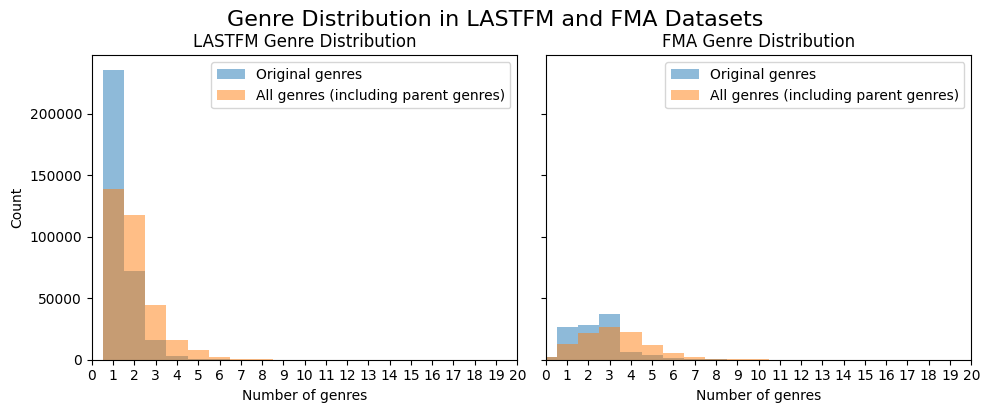

In [15]:
# PLOT GENRE DISTRIBUTION
def show_genres_distribution(LASTFM_genres_dict, LASTFM_all_genres_dict, FMA_tracks):
    """Show the genre distribution for LASTFM and FMA datasets side by side."""
    
    # Calculate genre counts for LASTFM
    lastfm_original_counts = [len(genres) for genres in LASTFM_genres_dict.values()]
    lastfm_all_counts = [len(genres) for genres in LASTFM_all_genres_dict.values()]

    # Calculate genre counts for FMA
    fma_original_counts = [len(genres) for genres in FMA_tracks['track', 'genres']]
    fma_all_counts = [len(genres) for genres in FMA_tracks['track', 'genres_all']]

    # Define the bins to perfectly match each integer count (e.g., 0 to 30)
    max_genres = max(
        max(lastfm_original_counts, default=0), 
        max(lastfm_all_counts, default=0),
        max(fma_original_counts, default=0), 
        max(fma_all_counts, default=0)
    )
    bins = range(0, max(20, max_genres) + 2)  # +2 to include the last bin edge properly

    # Create side-by-side plots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # LASTFM Plot
    axs[0].hist(lastfm_original_counts, bins=bins, alpha=0.5, label='Original genres', align='left')
    axs[0].hist(lastfm_all_counts, bins=bins, alpha=0.5, label='All genres (including parent genres)', align='left')
    axs[0].set_title('LASTFM Genre Distribution')
    axs[0].set_xlabel('Number of genres')
    axs[0].set_ylabel('Count')
    axs[0].set_xticks(bins)
    axs[0].set_xlim(0, 20)
    axs[0].legend()

    # FMA Plot
    axs[1].hist(fma_original_counts, bins=bins, alpha=0.5, label='Original genres', align='left')
    axs[1].hist(fma_all_counts, bins=bins, alpha=0.5, label='All genres (including parent genres)', align='left')
    axs[1].set_title('FMA Genre Distribution')
    axs[1].set_xlabel('Number of genres')
    axs[1].set_xticks(bins)
    axs[1].set_xlim(0, 20)
    axs[1].legend()

    plt.tight_layout()
    plt.suptitle('Genre Distribution in LASTFM and FMA Datasets', fontsize=16, y=1.02)
    plt.show()

show_genres_distribution(LASTFM_genres_dict, LASTFM_all_genres_dict, FMA_tracks)

In [16]:
# CONVERT TO ONE-HOT ENCODING & SAVE
# Convert to one-hot encoding
def one_hot_encode_LASTFM_genres(genres, genre_to_idx):
    '''One-hot encode all-genres for LASTFM dataset'''

    # Get number of genres
    num_genres = len(genre_to_idx) + 1 # 1 being the "no genre"

    # Initialise a one_hot vector
    one_hot = np.zeros(num_genres)
    
    # If no genres are present, return one-hot vector with 1 at the "no genre" index
    if len(genres) == 0:
        one_hot[num_genres-1] = 1
        return one_hot
    

    for genre in genres:
        one_hot[genre_to_idx[genre]] = 1

    return one_hot

# Create mapping from genre name to index
genre_to_idx = {genre: idx for idx, genre in enumerate(FMA_genres['title'].str.lower().str.replace('-', ' '))}

# Create one-hot encoding of genres from the LASTFM_all_genres_dict
one_hot_genres = {track_id: one_hot_encode_LASTFM_genres(genres, genre_to_idx) for track_id, genres in LASTFM_all_genres_dict.items()}
one_hot_genres = pd.DataFrame.from_dict(one_hot_genres, orient='index')

# Save
one_hot_genres.to_csv(paths.TEMP_D + 'LASTFM_one_hot_genres.tsv', sep='\t')

In [24]:
matching_tags = FMA_genres_set.intersection(LASTFM_tags_set)
show_most_common_LASTFM_tags(LASTFM_tags_dict_50, matching_tags, most_common_num=5000)

LASTFM Tag          Count     Most similar FMA genres
indie               22218     ['indian', 'indie rock']
female vocalists    16128     ['middle east', 'free folk']
alternative         15296     ['alternative hip hop', 'international']
soul                11978     ['soul rnb', 'surf']
classic rock        9219      ['classical', 'space rock']
80s                 8947      ['surf', 'salsa']
alternative rock    8038      ['alternative hip hop', 'noise rock']
reggae              7284      ['shoegaze', 'breakbeat']
hard rock           6883      ['loud rock', 'space rock']
trance              6575      ['dance', 'tango']
oldies              6552      ['noise', 'disco']
progressive rock    5907      ['progressive', 'post rock']
chillout            5850      ['chill out', 'country']
60s                 5274      ['surf', 'salsa']
rnb                 4928      ['soul rnb', 'drone']
electronica         4906      ['electronic', 'electro punk']
punk rock           4810      ['post rock', 'loud

In [ ]:
for k, v in lastfm_dict.items()
    print(k, v)
    break

In [25]:
def get_ids_w_tag(tag):
    ids = []
    for track_id, tags in LASTFM_tags_dict_50.items():
        if tag in tags:
            ids.append(track_id)
    
    return ids

get_ids_w_tag('melancholic')

['TRJJENO128F422AD8F',
 'TRJJNCN128E079225E',
 'TRJJSME128F425B9AD',
 'TRJPBLB12903CB73DC',
 'TRJGMJG128F92E55EA',
 'TRJVKAU12903CA839D',
 'TRJVKNO128F42646BF',
 'TRJLAUR128F429E0F5',
 'TRJDYVC128F1463BD2',
 'TRJAJMI128F92FE3B9',
 'TRJOHCN128F92CD9A2',
 'TRJOZYU128F1462C57',
 'TRJTJQZ128F9327999',
 'TRJTQJF128E0787D88',
 'TRJFKJW128F42914A4',
 'TRJYEGP12903CDEDB3',
 'TRJXXGU128F932DBC6',
 'TRJHRGY128F9327A83',
 'TRJSDPA128F14588E7',
 'TRJSINW128F42712BB',
 'TRJZISQ12903CB4901',
 'TRJZNJT12903CA839E',
 'TRPJUMF128F92E3095',
 'TRPJEUJ128F9328E53',
 'TRPJEYC128F93294DF',
 'TRPPTSN128F931C960',
 'TRPGUYI128F931E95B',
 'TRPGNVL128F423ED58',
 'TRPLOYO128F931B3D0',
 'TRPLNHN128F93040C3',
 'TRPLZUU128F42460B5',
 'TRPDEZW128F9343F0E',
 'TRPDXAA128F42B93E4',
 'TRPACUP128F92D6BC3',
 'TRPODOZ12903CBFE7C',
 'TRPOXUW128F932A335',
 'TRPOZWR128F147200C',
 'TRPUIVK12903D032A3',
 'TRPUEPH128F4230D30',
 'TRPIUTX12903CE750D',
 'TRPIXTW128F149493D',
 'TRPTNFQ128F42868F2',
 'TRPCKNJ128F422953F',
 'TRPROSB12

In [17]:
LASTFM_tags_dict_50

{'TRJJJIH128F92E1423': ['metal',
  'visual kei',
  'jrock',
  'cover',
  'dark',
  'blood jrock metal visual key japanese rock'],
 'TRJJJAI128F933B0F8': ['country', 'bluegrass', 'alt country', 'americana'],
 'TRJJJHQ128F429E687': ['hip hop'],
 'TRJJJMV128F4242917': ['gammarec'],
 'TRJJJAM128F425C444': ['chanson francaise'],
 'TRJJJCW128F42218C7': ['scream'],
 'TRJJJQY128F4295342': ['rock', 'punk', 'chez nata san'],
 'TRJJJCD128E079298A': ['hard rock', 'rock'],
 'TRJJJWL128E0790E86': ['reggae'],
 'TRJJJCI128F4265FF0': ['dub'],
 'TRJJJAG12903CC7B84': ['synthpop'],
 'TRJJJZV128F4221E2F': ['west coast rap'],
 'TRJJJQM128EF35BFF1': ['rock', 'christian'],
 'TRJJJWA128F92FE4E4': ['soul', 'disco'],
 'TRJJJYF12903CBB80B': ['yean know'],
 'TRJJJBN128F92F828B': ['indie'],
 'TRJJJPE128F423B2A3': ['spiritual', 'shoshannah', 'the healing piano'],
 'TRJJJDH128F421DD6D': ['blues', 'female vocals', 'blues jazz singers'],
 'TRJJJDQ12903CD8415': ['rap', 'hip hop', 'experimental', 'idm', 'glitch'],
 'TRJJ

## Compare low-level features between FMA & LASTFM

In [4]:
# LOAD LASTFM ONE-HOT & GET TRACKS W/ GENRES
one_hot_genres = pd.read_csv(paths.TEMP_D + 'LASTFM_one_hot_genres.tsv', sep='\t').set_index('Unnamed: 0')
tracks_w_genres = one_hot_genres.index
print(f"We have {len(tracks_w_genres)} tracks with genres")

We have 328933 tracks with genres


In [9]:
# GET MSD LOW LEVEL FEATURES - DOWNLOADED FROM https://www.ifs.tuwien.ac.at/mir/msd/download.html#groundtruth
def read_arff(filepath):
    '''Read an .arff file and return a pandas dataframe'''
    
    # Get the column names
    colnames = []
    with open(filepath, 'r') as f:
        for line in f:
            if not line.startswith('@'):
                break
            if line.lower().startswith('@attribute'):
                colnames.append(line.split(' ')[1])

    # Return a pandas dataframe
    return pd.read_csv(filepath, skiprows=len(colnames)+3, names=colnames)

def get_msd_features(tracks_w_genres):
    '''
    Join the different files with MSD features
    Only keep tracks with genres
    Downloaded from https://www.ifs.tuwien.ac.at/mir/msd/download.html#groundtruth
    '''


    # Paths for LASTFM features
    mfcc_filepath = paths.MSD_D + 'msd-jmir-mfcc-all-v1.0.arff'
    all_f_filepath = paths.MSD_D + 'msd-jmir-spectral-all-all-v1.0.arff'
    all_f_derivatives_filepath = paths.MSD_D + 'msd-jmir-spectral-all-derivatives-all-v1.0.arff'
    timbral_f_filepath = paths.MSD_D + 'msd-marsyas-timbral-v1.0.arff'

    # Tracks are within ''. Change index to match
    tracks_w_genres_set = set(f"'{track}'" for track in tracks_w_genres)


    # Read the MSD feature files & only keep tracks with genres
    combined_df = []
    for path in [mfcc_filepath, all_f_filepath, all_f_derivatives_filepath]:
        # Read the file from the .arff
        df = read_arff(path)

        # Keep only tracks with genres
        df = df[df['MSD_TRACKID'].isin(tracks_w_genres_set)]

        # Add to combined df
        combined_df.append(df)


    # Get the final combined dataframe
    msd_features = pd.merge(combined_df[0], combined_df[1], on='MSD_TRACKID')
    msd_features = pd.merge(msd_features, combined_df[2], on='MSD_TRACKID')

    # Remove '' from TRACKID
    msd_features['MSD_TRACKID'] = msd_features['MSD_TRACKID'].apply(lambda x: x.strip("'"))

    # Add timbral features
    timbral_df = read_arff(timbral_f_filepath)
    timbral_df = timbral_df[timbral_df['track_id'].isin(tracks_w_genres)]
    msd_features = pd.merge(msd_features, timbral_df, left_on='MSD_TRACKID', right_on='track_id')    

    # Make trackid the index
    msd_features = msd_features.set_index('MSD_TRACKID')

    return msd_features

msd_features = get_msd_features(tracks_w_genres)

# Save the features
msd_features.to_csv(paths.TEMP_D + 'msd_features.tsv', sep='\t')

msd_features.head()

,MFCC_Overall_Standard_Deviation_1,MFCC_Overall_Standard_Deviation_2,MFCC_Overall_Standard_Deviation_3,MFCC_Overall_Standard_Deviation_4,MFCC_Overall_Standard_Deviation_5,MFCC_Overall_Standard_Deviation_6,MFCC_Overall_Standard_Deviation_7,MFCC_Overall_Standard_Deviation_8,MFCC_Overall_Standard_Deviation_9,MFCC_Overall_Standard_Deviation_10,...,Std_Acc5_Std_Mem20_PeakRatio_Chroma_D_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Chroma_D#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Chroma_E_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Chroma_F_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Chroma_F#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Chroma_G_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Chroma_G#_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Average_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,Std_Acc5_Std_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0,track_id
MSD_TRACKID,,,,,,,,,,,,,,,,,,,,,
TRMMMYQ128F932D901,37.50,4.198,3.025,2.923,2.200,2.063,1.981,1.916,1.566,1.645,...,0.000700,0.000714,0.000740,0.000722,0.000673,0.000654,0.000666,0.113672,0.248798,TRMMMYQ128F932D901
TRMMMKI128F931D80D,54.71,4.207,4.952,3.718,2.461,2.497,2.309,2.001,1.768,1.707,...,0.001112,0.001176,0.001186,0.001245,0.001222,0.001198,0.001080,0.286647,3.282206,TRMMMKI128F931D80D
TRMMMQY128F92F0EA3,43.22,3.611,3.689,2.899,2.259,2.107,1.930,1.607,1.583,1.503,...,0.000404,0.000406,0.000407,0.000390,0.000357,0.000353,0.000412,0.068049,0.206265,TRMMMQY128F92F0EA3
TRMMMPN128F426610E,41.74,4.314,3.029,2.502,2.222,2.113,1.631,1.497,1.379,1.374,...,0.001056,0.001039,0.001018,0.001010,0.001039,0.001050,0.001048,0.119544,0.424948,TRMMMPN128F426610E
TRMMMNO128F93539AA,35.43,4.673,3.725,2.962,2.311,2.282,2.023,1.674,1.712,1.948,...,0.000996,0.001047,0.001156,0.001097,0.001072,0.000982,0.000800,0.206609,1.085369,TRMMMNO128F93539AA


In [8]:
# GET MOST SIMILAR MSD FEATURES TO FMA FEATURES
def get_most_similar_string(target, words, num_similar: int) -> list:
    return difflib.get_close_matches(target, words, n=num_similar, cutoff=0.0)

# Get index 0 of FMA columns
FMA_feature_cols = set(' '.join(col[:1]) for col in FMA_features.columns)

# Reduce the name of the feature columns
MSD_patterns = [
        # Timbral features
        (r'(Std|Mean)_Acc5_(Std|Mean)_Mem20_', ''),       # Remove Acc5_Mem20 prefix
        (r'_HopSize512_WinSize512_Sum_AudioCh0', ''),      # Remove audio channel suffix
        (r'MFCC\d+', 'MFCC'),                              # Standardize MFCC names
        (r'Chroma_\w#?', 'Chroma'),                         # Standardize Chroma names

        # Other features
        (r'_\d+(_[xy])?$', ''),                            # Remove the _# or _#_x suffix
        (r'^(Derivative_of_)?(Standard_Deviation_of_)?(Running_Mean_of_)?', ''),  # Remove prefixes
        (r'(_Overall)?(_Average)?(_Standard_Deviation)?', '')  # Remove suffixes
]
MSD_cols = msd_features.columns
for pattern, replacement in MSD_patterns:
    MSD_cols = set(re.sub(pattern, replacement, col) for col in MSD_cols)

for col in MSD_cols:
    most_similar_FMA_col = get_most_similar_string(col, FMA_feature_cols, 2)
    print(f"{col:<80}{most_similar_FMA_col}")

Flux_Power_powerFFT_WinHamming                                                  ['spectral_contrast', 'spectral_centroid']
track_id                                                                        ['spectral_centroid', 'spectral_bandwidth']
PeakRatio_Chroma_Power_powerFFT_WinHamming                                      ['chroma_cens', 'chroma_cqt']
Spectral_Rolloff_Point                                                          ['spectral_rolloff', 'spectral_contrast']
Rolloff_Power_powerFFT_WinHamming                                               ['spectral_rolloff', 'spectral_contrast']
Spectral_Variability                                                            ['spectral_bandwidth', 'spectral_rolloff']
Root_Mean_Square                                                                ['tonnetz', 'rmse']
ZeroCrossings                                                                   ['chroma_cens', 'spectral_rolloff']
Fraction_Of_Low_Energy_Windows                              

In [12]:
print([col for col in FMA_features.columns])
FMA_feature_cols

# Obtained from MSD features:
# MFCC  - MFCC
# RMSE - Root_mean_square
# Spectral centroid/rolloff - Spectral centroid/rolloff
# ZCR - zero-crossing rate

# From MSD timbral features:
# Chroma - Some chroma features


# Spectral bandwidth - NONE
# Spectral contrast - NONE
# Tonnetz - NONE


[('chroma_cens', 'kurtosis', '01'), ('chroma_cens', 'kurtosis', '02'), ('chroma_cens', 'kurtosis', '03'), ('chroma_cens', 'kurtosis', '04'), ('chroma_cens', 'kurtosis', '05'), ('chroma_cens', 'kurtosis', '06'), ('chroma_cens', 'kurtosis', '07'), ('chroma_cens', 'kurtosis', '08'), ('chroma_cens', 'kurtosis', '09'), ('chroma_cens', 'kurtosis', '10'), ('chroma_cens', 'kurtosis', '11'), ('chroma_cens', 'kurtosis', '12'), ('chroma_cens', 'max', '01'), ('chroma_cens', 'max', '02'), ('chroma_cens', 'max', '03'), ('chroma_cens', 'max', '04'), ('chroma_cens', 'max', '05'), ('chroma_cens', 'max', '06'), ('chroma_cens', 'max', '07'), ('chroma_cens', 'max', '08'), ('chroma_cens', 'max', '09'), ('chroma_cens', 'max', '10'), ('chroma_cens', 'max', '11'), ('chroma_cens', 'max', '12'), ('chroma_cens', 'mean', '01'), ('chroma_cens', 'mean', '02'), ('chroma_cens', 'mean', '03'), ('chroma_cens', 'mean', '04'), ('chroma_cens', 'mean', '05'), ('chroma_cens', 'mean', '06'), ('chroma_cens', 'mean', '07'), ('

{'chroma_cens',
 'chroma_cqt',
 'chroma_stft',
 'mfcc',
 'rmse',
 'spectral_bandwidth',
 'spectral_centroid',
 'spectral_contrast',
 'spectral_rolloff',
 'tonnetz',
 'zcr'}

In [13]:
# COMPARE LASTFM & FMA ON COINCIDING SONGS

# 1. Get list of FMA and LASTFM tracks that coincide
# 2. Check for genre overlap between the two tracks
# 3. Check for feature overlap between the two tracks
#    For that, create a heatmap, comparing the similarity between the features. See whether there is some feature which is very well correlated.
#    Take into consideration that we might get very bad results, as the features have been computed in a different way

In [14]:
def get_matching_tracks(FMA_tracks, paths):
    """Retrieve matching tracks between FMA and MSD datasets as (LASTFM_track_id, FMA_track_id, artist, title) tuples."""
    
    # Create a mapping from (title, artist) to FMA track ID
    FMA_title_artist_to_id = {
        (title, artist): track_id
        for track_id, title, artist in zip(
            FMA_tracks.index,
            FMA_tracks[('track', 'title')],
            FMA_tracks[('artist', 'name')]
        )
    }

    # Get list of tracks with similar tracks from LASTFM
    with open(paths.LASTFM_SIMILAR_TRACKS) as f:
        tracks_with_similar = f.read().splitlines()

    # List to store the matched tuples
    matched_tracks = []

    for track_id in tracks_with_similar:
        rel_track_path = f'{track_id[2]}/{track_id[3]}/{track_id[4]}/{track_id}.json'

        # Check in both train and test directories
        for supfolder in [paths.LASTFM_TEST_F, paths.LASTFM_TRAIN_f]:
            track_path = supfolder + rel_track_path
            if not os.path.exists(track_path):
                continue

            # Load track metadata
            with open(track_path) as f:
                track_dict = json.load(f)

                title = track_dict['title']
                artist = track_dict['artist']

                # Check if this (title, artist) exists in FMA
                if (title, artist) in FMA_title_artist_to_id:
                    FMA_track_id = FMA_title_artist_to_id[(title, artist)]
                    matched_tracks.append((track_id, FMA_track_id, artist, title))

    print(f"Found {len(matched_tracks)} matching tracks between MSD and FMA.")
    return matched_tracks

# Example call to the function
matched_tracks = get_matching_tracks(FMA_tracks, paths)

Found 453 matching tracks between MSD and FMA.


In [27]:
# PROVIDED BY CHATGPT

def check_genre_overlap(matched_tracks, FMA_tracks, LASTFM_all_genres_dict):
    """Check for genre overlap between coinciding tracks in FMA and LASTFM datasets."""
    
    id_to_genre = FMA_genres['title'].str.lower().str.replace('-', ' ').to_dict()

    genre_overlaps = []

    for lastfm_id, fma_id, artist, title in matched_tracks:
        # Get FMA genres directly
        fma_genres = set(FMA_tracks.loc[fma_id, ('track', 'genres_all')])

        # Map genres to its name
        fma_genres = set(id_to_genre[genre_id] for genre_id in fma_genres)        

        # Get LASTFM genres directly
        lastfm_genres = set(LASTFM_all_genres_dict.get(lastfm_id, []))

        # Find the intersection of genres
        overlapping_genres = fma_genres & lastfm_genres
        genre_overlaps.append((lastfm_id, fma_id, artist, title, fma_genres, lastfm_genres, overlapping_genres))

    print(f"Checked genre overlap for {len(genre_overlaps)} tracks.")
    return genre_overlaps

# Step 2: Check genre overlap
genre_overlaps = check_genre_overlap(matched_tracks, FMA_tracks, LASTFM_all_genres_dict)
print(genre_overlaps)

Checked genre overlap for 453 tracks.
[('TRACCYC128F930B379', 18805, 'Chandeliers', 'The Durks', {'electronic'}, set(), set()), ('TRADPJD12903D031C6', 83969, 'Foot Village', 'Reggae War Zone', {'loud rock', 'rock', 'noise rock'}, set(), set()), ('TRAEJYY128F4218203', 126683, 'The Red Thread', "Sailin' On", {'country & western', 'americana', 'country', 'indie rock', 'rock'}, set(), set()), ('TRAGYML128F4286683', 10160, 'Thee Oh Sees', 'It Killed Mom', {'garage', 'rock'}, set(), set()), ('TRAIZBQ128F92F02A7', 33538, 'Calexico', 'Roka', {'rock'}, {'spanish', 'americana', 'country', 'indie rock', 'folk', 'international', 'rock', 'europe'}, {'rock'}), ('TRAJXWL12903D0537F', 129682, 'Holly Golightly & The Brokeoffs', 'When He Comes', {'country', 'folk', 'blues'}, set(), set()), ('TRAKKTI128F42B4F25', 33542, 'Calexico', 'Two Silver Trees', {'rock'}, {'indie rock', 'rock', 'house', 'electronic', 'chill out'}, {'rock'}), ('TRALDEB128F428CE7A', 4804, 'Harvey Milk', 'The Anvil Will Fall', {'rock'

In [ ]:
import pandas as pd

# Prepare the data from genre_overlaps
overlap_data = [
    {
        "lastfm_id": lastfm_id,
        "fma_id": fma_id,
        "artist": artist,
        "title": title,
        "fma_genres": fma_genres,
        "lastfm_genres": lastfm_genres,
        "overlapping_genres": overlapping_genres,
        "num_fma_genres": len(fma_genres),
        "num_lastfm_genres": len(lastfm_genres),
        "num_overlapping_genres": len(overlapping_genres),
    }
    for lastfm_id, fma_id, artist, title, fma_genres, lastfm_genres, overlapping_genres in genre_overlaps
]

# Convert to DataFrame
overlap_df = pd.DataFrame(overlap_data)

# Calculate some statistics
total_tracks = len(overlap_df)
tracks_with_overlap = overlap_df[overlap_df['num_overlapping_genres'] > 0].shape[0]
average_overlap = overlap_df['num_overlapping_genres'].mean()
average_fma_genres = overlap_df['num_fma_genres'].mean()
average_lastfm_genres = overlap_df['num_lastfm_genres'].mean()
average_overlap_ratio = (overlap_df['num_overlapping_genres'] / overlap_df['num_fma_genres']).mean()

# Create a contingency table
contingency_table = pd.crosstab(
    overlap_df['num_fma_genres'], 
    overlap_df['num_overlapping_genres']
)

# Display the results
summary_stats = {
    "Total Tracks": total_tracks,
    "Tracks with Genre Overlap": tracks_with_overlap,
    "Percentage with Overlap": tracks_with_overlap / total_tracks * 100,
    "Average Number of FMA Genres": average_fma_genres,
    "Average Number of LASTFM Genres": average_lastfm_genres,
    "Average Number of Overlapping Genres": average_overlap,
    "Average Overlap Ratio": average_overlap_ratio,
}

display(contingency_table)

summary_stats

num_overlapping_genres,0,1,2,3,4,5
num_fma_genres,,,,,,
0,4,0,0,0,0,0
1,77,31,0,0,0,0
2,67,27,19,0,0,0
3,79,23,10,10,0,0
4,34,11,15,2,3,0
5,25,5,3,0,0,0
6,2,1,3,0,0,1
7,0,1,0,0,0,0


{'Total Tracks': 453,
 'Tracks with Genre Overlap': 165,
 'Percentage with Overlap': 36.423841059602644,
 'Average Number of FMA Genres': np.float64(2.5916114790286975),
 'Average Number of LASTFM Genres': np.float64(1.0485651214128036),
 'Average Number of Overlapping Genres': np.float64(0.5562913907284768),
 'Average Overlap Ratio': np.float64(0.23814296319864248)}

: 

Error processing track TRAKKTI128F42B4F25 and 33542: 'TRAKKTI128F42B4F25'


/home/cdt_wsl/wsl_courses/Melody-Match/venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/cdt_wsl/wsl_courses/Melody-Match/venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


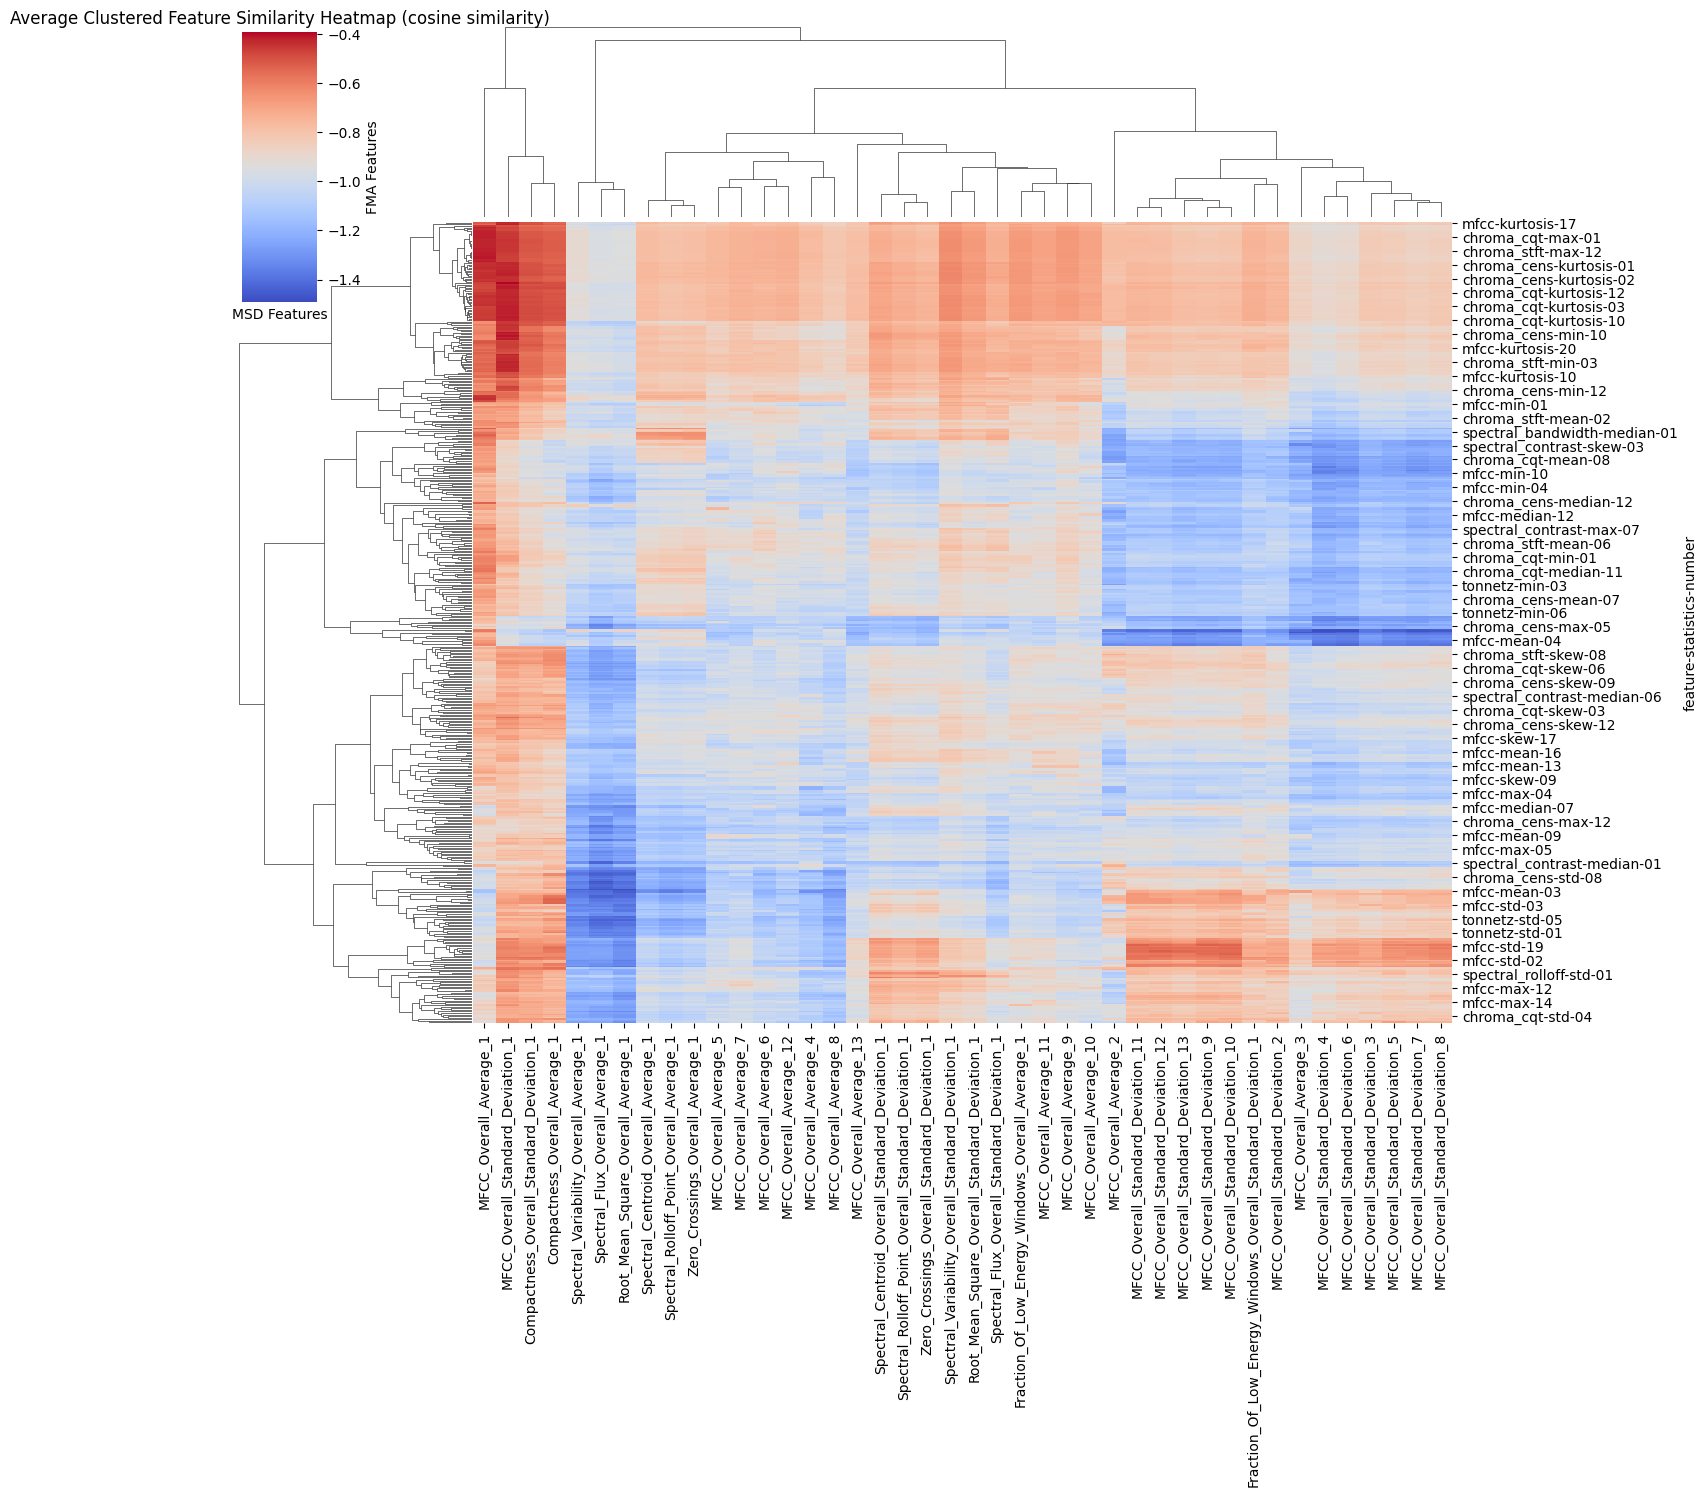

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

def standardize_features(FMA_features, MSD_features):
    """Standardize both FMA and MSD features to have mean 0 and standard deviation 1."""
    
    # Initialize the standard scaler
    scaler = StandardScaler()
    
    # Standardize FMA features
    FMA_standardized = pd.DataFrame(
        scaler.fit_transform(FMA_features),
        index=FMA_features.index,
        columns=FMA_features.columns
    )
    
    # Standardize MSD features
    MSD_standardized = pd.DataFrame(
        scaler.fit_transform(MSD_features),
        index=MSD_features.index,
        columns=MSD_features.columns
    )
    
    return FMA_standardized, MSD_standardized

def plot_average_feature_similarity_heatmap(matched_tracks, FMA_features, MSD_features, method='correlation'):
    """Create a heatmap showing the average feature similarity between FMA and MSD datasets across all matched tracks."""

    if not matched_tracks:
        print("No matched tracks available.")
        return

    # Initialize an accumulator for the similarity matrices
    cumulative_similarity_matrix = np.zeros((FMA_features.shape[1], MSD_features.shape[1]))
    valid_track_count = 0

    for lastfm_id, fma_id, artist, title in matched_tracks:
        try:
            # Get FMA and MSD feature vectors for the track
            fma_feature_vector = FMA_features.loc[fma_id].values.reshape(-1, 1)
            msd_feature_vector = MSD_features.loc[lastfm_id].values.reshape(-1, 1)

            # Calculate similarity between features
            if method == 'correlation':
                similarity_matrix = np.corrcoef(fma_feature_vector[:, 0], msd_feature_vector[:, 0])
            else:
                similarity_matrix = -pairwise_distances(fma_feature_vector, msd_feature_vector, metric='euclidean')

            # Handle potential infinite or NaN values by replacing them with a low similarity score
            similarity_matrix = np.nan_to_num(similarity_matrix, nan=-1.0, posinf=-1.0, neginf=-1.0)

            # Accumulate the similarity matrix
            cumulative_similarity_matrix += similarity_matrix
            valid_track_count += 1

        except Exception as e:
            print(f"Error processing track {lastfm_id} and {fma_id}: {e}")
            continue

    # Calculate the average similarity matrix
    if valid_track_count > 0:
        average_similarity_matrix = cumulative_similarity_matrix / valid_track_count
    else:
        print("No valid tracks processed.")
        return

    # Create labels for heatmap
    fma_feature_labels = FMA_features.columns
    msd_feature_labels = MSD_features.columns

    # Create a DataFrame for the heatmap
    similarity_df = pd.DataFrame(average_similarity_matrix, index=fma_feature_labels, columns=msd_feature_labels)

    # Plot the average similarity heatmap with clustering
    sns.clustermap(similarity_df, cmap='coolwarm', method='average', metric='euclidean', figsize=(15, 15))
    plt.title(f'Average Clustered Feature Similarity Heatmap ({method} similarity)')
    plt.xlabel('MSD Features')
    plt.ylabel('FMA Features')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Standardise
FMA_standardized, MSD_standardized = standardize_features(FMA_features, msd_features)

# Plot the average feature similarity heatmap across all matched tracks
plot_average_feature_similarity_heatmap(matched_tracks, FMA_standardized, MSD_standardized, method='cosine')